In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.5 MB/s 
     |████████████████████████████████| 596 kB 39.7 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
     |████████████████████████████████| 6.6 MB 33.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_excel('/content/Balenced_data.xlsx')
df

,Clickbaits,sentiments
0,22 Times Ariana Grande Was Actually Pretty Dam...,1
1,58 Things That Mildly Annoy Anyone Who Lives W...,1
2,24 Hilarious Tweets Every Book Lover Will Appr...,1
3,NASA Just Released A Breathtaking Photo Of Sou...,1
4,23 Words Only Disney Fans Will Really Understand,1
...,...,...
2193,to your second sechudle reminder,3
2194,weekly your shipment items will be delivered w...,3
2195,and i clearly don't owe for anyone my body,3
2196,when do you're bored how af,3


In [4]:
import numpy as np

seq_len = 512
num_samples = len(df)

Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

Xids.shape

(2198, 512)

In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i, phrase in enumerate(df['Clickbaits']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
Xids

array([[  101.,  2570.,  2335., ...,     0.,     0.,     0.],
       [  101.,  5388.,  2477., ...,     0.,     0.,     0.],
       [  101.,  2484., 26316., ...,     0.,     0.,     0.],
       ...,
       [  101.,  1998.,  1045., ...,     0.,     0.,     0.],
       [  101.,  2043.,  2079., ...,     0.,     0.,     0.],
       [  101., 17666.,  2015., ...,     0.,     0.,     0.]])

In [7]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [8]:
arr = df['sentiments'].values
arr = arr - 1
arr
# df['Sentiment'].unique()

array([0, 0, 0, ..., 2, 2, 2])

In [9]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(2198, 3)

In [10]:
labels[np.arange(num_samples), arr] = 1
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

## Input Pipeline

In [11]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [12]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [13]:
batch_size = 32

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(32, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(32, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(32, 3), dtype=tf.float64, name=None))>

In [14]:
split = 0.7

# we need to calculate how many batches must be taken to create 80% training set
size = int((Xids.shape[0] / batch_size) * split)

size

48

In [15]:
train_ds = dataset.take(size)
val_ds = dataset.skip(0)
# For validation


# free up memory
del dataset

In [16]:
len(train_ds)

48

# Build and train

In [17]:

from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-uncased')

# we can view the model using the summary method
bert.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [18]:
import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

x = tf.keras.layers.Dropout(0.3)(x)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

In [19]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [20]:
save_callback = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/bst_wt_fogg',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [21]:
model.load_weights('/content/drive/MyDrive/bst_wt_fogg')

##Polynomial Decay

In [ ]:
# from tensorflow.keras.optimizers.schedules import PolynomialDecay

# num_epochs = 10
# num_train_steps = len(train_ds) * num_epochs
# lr_scheduler = PolynomialDecay(
#     initial_learning_rate=2e-5,
#     end_learning_rate=0.,
#     decay_steps=num_train_steps
# )

## Scheduler

In [ ]:
# def scheduler(epoch, lr):
#     if epoch < 1:
#         return lr
#     else:
#         # return lr * tf.math.exp(-0.000001)
#         return lr/2

In [ ]:
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [22]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
# optimizer = tf.keras.optimizers.Adam(lr=lr_scheduler)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


##Exponential

In [ ]:
# initial_learning_rate = 0.1
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    # callbacks=[callback]
    callbacks=[save_callback]
)

Epoch 1/20
 2/48 [>.............................] - ETA: 57:03 - loss: 0.5538 - accuracy: 0.6875  

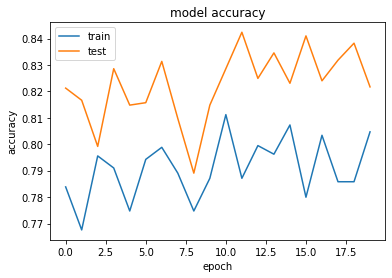

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

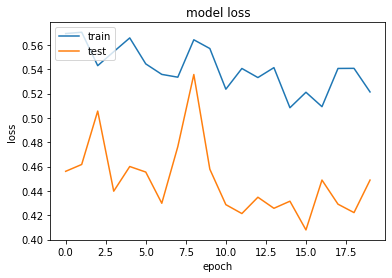

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('/content//drive/MyDrive/best_model_fogg')

INFO:tensorflow:Assets written to: /content//drive/MyDrive/best_model_fogg/assets


INFO:tensorflow:Assets written to: /content//drive/MyDrive/best_model_fogg/assets


In [ ]:
!zip -r /content/best_model.zip /content/best_model

  adding: content/best_model/ (stored 0%)
  adding: content/best_model/saved_model.pb (deflated 92%)
  adding: content/best_model/assets/ (stored 0%)
  adding: content/best_model/variables/ (stored 0%)
  adding: content/best_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/best_model/variables/variables.index (deflated 76%)
  adding: content/best_model/keras_metadata.pb (deflated 95%)


In [ ]:
from google.colab import files
files.download('/content/best_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load and Predict

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/bst_wt_fogg')

# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# predicted = model.predict(df['Tweet'])

In [ ]:
an = np.array([np.argmax(i) for i in predicted])
an
# arr

In [ ]:
score = model.evaluate(train_ds) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

3/3 [==============================] - 9s 1s/step - loss: 0.5062 - accuracy: 0.8125
Test loss: 0.5062158107757568
Test accuracy: 0.8125


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [ ]:
an = []

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Clickbaits'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    an.append(pred)

# df.head()

In [ ]:
an = np.array(an)
an

array([0, 0, 0, ..., 1, 2, 0])

In [ ]:
print(classification_report(arr, an))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       900
           1       0.84      0.82      0.83       666
           2       0.83      0.84      0.83       632

    accuracy                           0.84      2198
   macro avg       0.84      0.84      0.84      2198
weighted avg       0.84      0.84      0.84      2198



In [ ]:
conf = confusion_matrix(arr, an)

In [ ]:
conf

array([[823,  55,  22],
       [138, 497,  31],
       [159,  73, 400]])

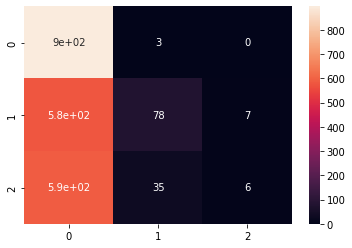

In [ ]:
import seaborn as sns
sns.heatmap(conf, annot=True)

In [ ]:
 from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, arr, an, cv=5, scoring='f1_macro')
scores

In [ ]:
stmt = input()
probs = model.predict(prep_data(stmt))[0]

probs

@TheRafaMafia Hey there! You can view the video here:  https://t.co/f2K2rqGf79 where you are briefly featured at 1:02. Enjoy!


array([0.92497486, 0.01838735, 0.01129976, 0.00166099, 0.02466378,
       0.00705248, 0.0119608 ], dtype=float32)

In [ ]:
import numpy as np

np.argmax(probs)

0

In [ ]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('test.tsv', sep='\t')
df.head()

In [ ]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

In [ ]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

In [ ]:
df.tail()